In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.model_selection import ParameterGrid

from recsys4daos.models import NLPSimilarity
from recsys4daos.utils import Timer
from recsys4daos.datasets import to_microsoft
from recsys4daos.evaluation import calculate_all_metrics
from recsys4daos.model_selection import cvtt_open, explore_hparams

import paths

import seaborn as sns
sns.set_theme()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/home/daviddavo/recsys4daos/.direnv/python-3.11/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Parameters

In [2]:
# Dataset config
ORG_NAME = 'Decentraland'

# Evaluation
K_RECOMMENDATIONS: list[int] = [1,3,5,10,15,100]
SPLITS_FREQ: str = 'W-THU' # split weekly
SPLITS_NORMALIZE = True # Wether or not to move everything to 00:00
LAST_FOLDS = 10 # Use just last 10 splits
LAST_FOLD_DATE_STR: str = None

# Search space config
WINDOW_SIZES = ['7d', '14d', '21d', '30d', '60d', '90d', '10YE']
MODEL_NAMES = [
    'all-mpnet-base-v2', # The one used in sbert's examples
    'all-distilroberta-v1',
    'all-MiniLM-L12-v2',
    'all-MiniLM-L6-v2',
]

OPTIM_METRIC = 'map@10'

In [3]:
# Parameters
EXECUTION_ID = "2024-09-04T10:00"
ORG_NAME = "Decentraland"
SPLITS_FREQ = "W-THU"
LAST_FOLDS = 10
SPLITS_NORMALIZE = True
LAST_FOLD_DATE_STR = "2023-07-13"


In [4]:
EMBEDDINGS_CACHE = Path(paths.DEFAULT_CACHE_PATH) / 'pln-embeddings'

# Load the dataset

In [5]:
dfp = paths.load_proposals(ORG_NAME, text=True)
dfv = paths.load_votes(ORG_NAME)

print(dfp.info())
print(dfv.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2213 entries, 0 to 2212
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 2213 non-null   object        
 1   author             2213 non-null   object        
 2   date               2213 non-null   datetime64[us]
 3   start              2213 non-null   datetime64[us]
 4   end                2213 non-null   datetime64[us]
 5   platform_proposal  2213 non-null   object        
 6   title              2213 non-null   object        
 7   description        2213 non-null   object        
dtypes: datetime64[us](3), object(5)
memory usage: 138.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116560 entries, 0 to 116559
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   id        116560 non-null  object        
 1   proposal  116560 non-n

In [6]:
df = to_microsoft(dfv)
df

,userID,itemID,timestamp,rating
0,0x30b1f4bd5476906f38385b891f2c09973196b742,312c5654-0806-5473-8243-dbd6311208ed,2021-05-24 15:29:29,1
1,0x30b1f4bd5476906f38385b891f2c09973196b742,f6bd4c7d-0d1e-5437-9cf9-e5e883522d3f,2021-05-24 15:30:54,1
2,0xd689478d44a438798ee0dc07657cce2135c0aef7,2dc28092-bb92-5c3f-8837-f8ed570d1a20,2021-05-24 15:38:54,1
3,0x862f109696d7121438642a78b3caa38f476db08b,2dc28092-bb92-5c3f-8837-f8ed570d1a20,2021-05-24 15:41:31,1
4,0x862f109696d7121438642a78b3caa38f476db08b,94c28bf3-501e-5925-98a3-b4ddbed07abf,2021-05-24 15:50:36,1
...,...,...,...,...
116555,0x28bf51f47e903925c00a03264c7e7a0576785600,e5fcfaed-fd89-547f-aba0-b682b2114a4b,2023-07-19 16:19:59,1
116556,0xdcd35e70c43c6f86c663a1919259cd9e818d9865,f41ed318-2f75-5a16-a798-6623e99fb55a,2023-07-19 17:54:31,1
116557,0x598f8af1565003ae7456dac280a18ee826df7a2c,858339c3-6902-52c5-ab98-bb5985327cbd,2023-07-19 17:57:35,1
116558,0x059d0025e4e1bb1a37f2c922e54b139bc1231ee0,f41ed318-2f75-5a16-a798-6623e99fb55a,2023-07-20 00:56:09,1


## Split in folds

In [7]:
all_folds = { f.end:f for f in cvtt_open(
    df, SPLITS_FREQ, dfp.reset_index(), remove_not_in_train_col='userID', last_fold=LAST_FOLD_DATE_STR,
)}
last_folds_idx = list(all_folds.keys())[-LAST_FOLDS:]
last_folds_idx

[Timestamp('2023-05-11 00:00:00'),
 Timestamp('2023-05-18 00:00:00'),
 Timestamp('2023-05-25 00:00:00'),
 Timestamp('2023-06-01 00:00:00'),
 Timestamp('2023-06-08 00:00:00'),
 Timestamp('2023-06-15 00:00:00'),
 Timestamp('2023-06-22 00:00:00'),
 Timestamp('2023-06-29 00:00:00'),
 Timestamp('2023-07-06 00:00:00'),
 Timestamp('2023-07-13 00:00:00')]

# Similarity PLN

In [8]:
def testHParamsPLNSimilarity(fold, window_size, model_name):
    f = all_folds[fold]
    
    model = NLPSimilarity(dfp, EMBEDDINGS_CACHE, model_name=model_name)

    offset = pd.tseries.frequencies.to_offset(window_size)
    train = f.train[f.train['timestamp'] > (f.end - offset)]

    with Timer() as t_fit:
        model.fit(train)

    with Timer() as t_rec:
        # Truncate the top_k
        top_k = max(K_RECOMMENDATIONS)
        users = np.intersect1d(f.test['userID'].unique(), train['userID'].unique())
        recs = model.recommend_k_items(users, top_k=min(len(f.open_proposals), top_k), recommend_from=f.open_proposals)
    
    return {
        'time_train': t_fit.time,
        'time_rec': t_rec.time,
        'rec_users': len(users),
        **calculate_all_metrics(f.test, recs, K_RECOMMENDATIONS),
    }

# testHParamsPLNSimilarity(last_folds_idx[0], '14D', MODEL_NAMES[0])

In [9]:
# Populate the cache of embeddings for each model
from recsys4daos.models.nlp import NLPModel

for m in MODEL_NAMES:
    NLPModel(dfp, EMBEDDINGS_CACHE, model_name=m).fit()

In [10]:
results = explore_hparams(
    testHParamsPLNSimilarity,
    ParameterGrid({
        'fold': last_folds_idx,
        'model_name': MODEL_NAMES,
        'window_size': WINDOW_SIZES,
    }),
    paths.hparams_progress('pln-similarity', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE),
)
mdf = pd.DataFrame(results)
mdf

Restored checkpoint from ../.cache/Decentraland/hparams-pln-similarity_W-THU_normalize.pkl with 280 results


  0%|          | 0/280 [00:00<?, ?it/s]

,fold,model_name,window_size,time_train,time_rec,rec_users,precision@1,precision@3,precision@5,precision@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
0,2023-05-11,all-mpnet-base-v2,7d,0.145332,0.001958,77,0.155844,0.177489,0.171429,0.190909,...,0.733179,0.957560,1.0,0.295238,0.360660,0.414038,0.457788,0.457788,0.457788,0.301964
1,2023-05-11,all-mpnet-base-v2,14d,0.233730,0.002217,98,0.500000,0.397959,0.316327,0.225510,...,0.846392,0.978134,1.0,0.420092,0.680193,0.748892,0.791154,0.791154,0.791154,0.160431
2,2023-05-11,all-mpnet-base-v2,21d,0.485662,0.002346,104,0.490385,0.378205,0.309615,0.221154,...,0.828171,0.981799,1.0,0.457540,0.692761,0.755415,0.798176,0.798176,0.798176,0.160385
3,2023-05-11,all-mpnet-base-v2,30d,0.589779,0.002711,116,0.491379,0.356322,0.289655,0.199138,...,0.756004,0.925493,1.0,0.472243,0.688638,0.747234,0.780200,0.780200,0.780200,0.164064
4,2023-05-11,all-mpnet-base-v2,60d,1.548592,0.003631,127,0.472441,0.341207,0.281890,0.198425,...,0.769985,0.958193,1.0,0.506964,0.705153,0.768503,0.804099,0.804099,0.804099,0.167768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,2023-07-13,all-MiniLM-L6-v2,21d,0.463686,0.002425,96,0.302083,0.250000,0.210417,0.188542,...,0.653374,0.862293,1.0,0.473357,0.544234,0.560143,0.605178,0.628941,0.628941,0.170006
276,2023-07-13,all-MiniLM-L6-v2,30d,0.378141,0.002523,102,0.333333,0.251634,0.209804,0.188235,...,0.655966,0.864988,1.0,0.447185,0.519094,0.553630,0.601368,0.627346,0.627346,0.170984
277,2023-07-13,all-MiniLM-L6-v2,60d,0.737819,0.002995,110,0.290909,0.254545,0.207273,0.190000,...,0.657274,0.861628,1.0,0.471488,0.513817,0.544660,0.595013,0.623523,0.624725,0.175087
278,2023-07-13,all-MiniLM-L6-v2,90d,1.063263,0.003764,122,0.270492,0.245902,0.216393,0.186066,...,0.663890,0.842953,1.0,0.494911,0.540595,0.576712,0.629201,0.657711,0.658913,0.179664


<Axes: xlabel='window_size', ylabel='map@10'>

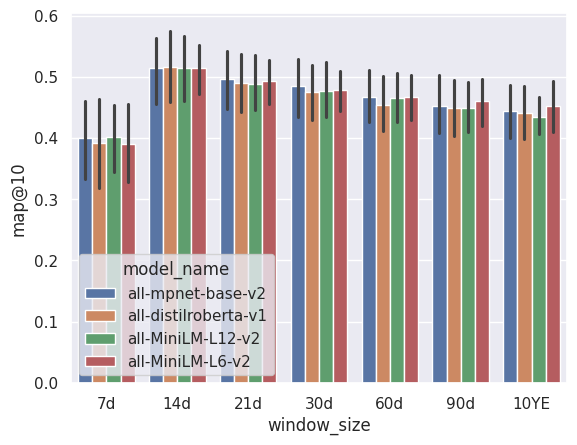

In [11]:
sns.barplot(mdf, x='window_size', y=OPTIM_METRIC, hue='model_name')

## Best overall hparams

In [12]:
display_columns = ['time_train'] + [ c for c in mdf.columns if c.endswith('@5') or c.endswith('@10') or c.endswith('@100') ]
hparam_cols = ['window_size', 'model_name']
overall_hparams = mdf[mdf['fold'] > last_folds_idx[0]].groupby(hparam_cols).mean().sort_values(OPTIM_METRIC, ascending=False)
overall_hparams[display_columns]

time_train  precision@5  precision@10  \
window_size model_name                                                    
14d         all-distilroberta-v1    0.282143     0.357354      0.263405   
            all-MiniLM-L12-v2       0.256933     0.351900      0.263436   
            all-mpnet-base-v2       0.316525     0.352587      0.265843   
            all-MiniLM-L6-v2        0.273264     0.346824      0.265621   
21d         all-mpnet-base-v2       0.306387     0.337873      0.256601   
            all-distilroberta-v1    0.341996     0.337589      0.256121   
            all-MiniLM-L12-v2       0.346214     0.333729      0.252593   
            all-MiniLM-L6-v2        0.325995     0.332643      0.257782   
30d         all-mpnet-base-v2       0.429152     0.329186      0.251588   
            all-MiniLM-L12-v2       0.356950     0.324213      0.248328   
            all-MiniLM-L6-v2        0.389763     0.322110      0.251861   
            all-distilroberta-v1    0.428952     0.327063      0.250743   
60d         all-MiniLM-L12-v2       0.896763     0.312639      0.240790   
            all-mpnet-base-v2       0.947306     0.317760      0.243957   
            all-MiniLM-L6-v2        0.855302     0.309292      0.245619   
90d         all-MiniLM-L6-v2        1.595865     0.304126      0.240885   
60d         all-distilroberta-v1    0.978456     0.310357      0.243109   
90d         all-MiniLM-L12-v2       1.580393     0.305534      0.235839   
            all-mpnet-base-v2       1.730084     0.306098      0.237686   
10YE        all-MiniLM-L6-v2       13.497752     0.292380      0.231365   
90d         all-distilroberta-v1    1.731294     0.306452      0.237987   
10YE        all-mpnet-base-v2      14.310665     0.294933      0.228602   
            all-MiniLM-L12-v2      13.534221     0.290515      0.227595   
            all-distilroberta-v1   14.280686     0.289302      0.229095   
7d          all-MiniLM-L12-v2       0.201870     0.289653      0.253575   
            all-mpnet-base-v2       0.202779     0.290829      0.256398   
            all-distilroberta-v1    0.219538     0.295078      0.256471   
            all-MiniLM-L6-v2        0.182888     0.290550      0.258352   

                                  precision@100    ndcg@5   ndcg@10  ndcg@100  \
window_size model_name                                                          
14d         all-distilroberta-v1       0.033186  0.360468  0.410483  0.451213   
            all-MiniLM-L12-v2          0.033171  0.357137  0.411406  0.451344   
            all-mpnet-base-v2          0.033186  0.356127  0.411293  0.450717   
            all-MiniLM-L6-v2           0.033186  0.351135  0.409146  0.448158   
21d         all-mpnet-base-v2          0.032459  0.377357  0.438774  0.484703   
            all-distilroberta-v1       0.032459  0.371860  0.434216  0.479724   
            all-MiniLM-L12-v2          0.032446  0.372655  0.433168  0.481652   
            all-MiniLM-L6-v2           0.032459  0.367612  0.434512  0.478385   
30d         all-mpnet-base-v2          0.032123  0.392283  0.458689  0.508470   
            all-MiniLM-L12-v2          0.032123  0.389078  0.455201  0.507028   
            all-MiniLM-L6-v2           0.032123  0.381924  0.454021  0.502578   
            all-distilroberta-v1       0.032123  0.384265  0.452290  0.502333   
60d         all-MiniLM-L12-v2          0.031796  0.423369  0.494267  0.556699   
            all-mpnet-base-v2          0.031796  0.420635  0.492649  0.553528   
            all-MiniLM-L6-v2           0.031789  0.411523  0.493916  0.549962   
90d         all-MiniLM-L6-v2           0.031317  0.426682  0.510600  0.571456   
60d         all-distilroberta-v1       0.031796  0.406809  0.485082  0.544998   
90d         all-MiniLM-L12-v2          0.031317  0.430922  0.506076  0.572443   
            all-mpnet-base-v2          0.031317  0.426680  0.502730  0.570701   
10YE        all-MiniLM-L6-v2           0.030198  0.460603  0.551313  0.618809   
9

In [13]:
best_avg_hparams = mdf.set_index(hparam_cols).loc[overall_hparams.iloc[0].name].reset_index().set_index(['fold', *hparam_cols])
paths.save_model_results(best_avg_hparams, 'plnsim-best-avg', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
best_avg_hparams

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Decentraland/models/plnsim-best-avg_W-THU_normalize.parquet


/tmp/ipykernel_3791768/971293119.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  best_avg_hparams = mdf.set_index(hparam_cols).loc[overall_hparams.iloc[0].name].reset_index().set_index(['fold', *hparam_cols])


,,,time_train,time_rec,rec_users,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
fold,window_size,model_name,,,,,,,,,,,,,,,,,,,,,
2023-05-11,14d,all-distilroberta-v1,0.234313,0.002190,98,0.469388,0.370748,0.318367,0.218367,0.168707,0.026122,0.330935,...,0.810496,0.954155,1.0,0.484058,0.718622,0.771429,0.807820,0.807820,0.807820,0.158653
2023-05-18,14d,all-distilroberta-v1,0.209916,0.002423,125,0.464000,0.440000,0.427200,0.355200,0.311467,0.056320,0.343195,...,0.577328,0.769794,1.0,0.208024,0.392769,0.513593,0.647440,0.702020,0.715906,0.190398
2023-05-25,14d,all-distilroberta-v1,0.209726,0.002132,93,0.505376,0.376344,0.307527,0.221505,0.177778,0.028925,0.385246,...,0.791115,0.901411,1.0,0.501048,0.650911,0.711861,0.773567,0.788292,0.790392,0.159409
2023-06-01,14d,all-distilroberta-v1,0.338698,0.001932,77,0.363636,0.411255,0.415584,0.305195,0.217316,0.032597,0.277228,...,0.927745,1.000000,1.0,0.292532,0.564059,0.661490,0.702841,0.706629,0.706629,0.151544
2023-06-08,14d,all-distilroberta-v1,0.145981,0.001929,82,0.548780,0.463415,0.414634,0.296341,0.208130,0.031220,0.381356,...,0.943191,1.000000,1.0,0.403360,0.615801,0.706505,0.767751,0.770727,0.770727,0.153518
2023-06-15,14d,all-distilroberta-v1,0.308209,0.001972,78,0.512821,0.405983,0.358974,0.278205,0.229915,0.034615,0.303030,...,0.759090,0.993590,1.0,0.298225,0.506635,0.609868,0.693252,0.701911,0.701911,0.158764
2023-06-22,14d,all-distilroberta-v1,0.320706,0.002094,103,0.417476,0.317152,0.299029,0.209709,0.166343,0.025049,0.290541,...,0.815002,0.998382,1.0,0.468752,0.593788,0.667153,0.700546,0.706290,0.706290,0.161166
2023-06-29,14d,all-distilroberta-v1,0.175558,0.001805,60,0.600000,0.472222,0.406667,0.231667,0.154444,0.023167,0.336449,...,1.000000,1.000000,1.0,0.514352,0.749187,0.833333,0.833333,0.833333,0.833333,0.143103
2023-07-06,14d,all-distilroberta-v1,0.378564,0.002378,140,0.400000,0.383333,0.345714,0.281429,0.233810,0.038286,0.224900,...,0.759882,0.922226,1.0,0.324622,0.478297,0.577263,0.678375,0.705302,0.714721,0.194706


## best hparams by fold

In [14]:
print("Best hyperparams by fold", OPTIM_METRIC)
best_hparams = mdf.sort_values(OPTIM_METRIC,ascending=False).drop_duplicates(['fold'], keep='first').sort_values('fold').set_index(['fold', 'model_name', 'window_size'])
paths.save_model_results(best_hparams, 'plnsim-best-val', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
best_hparams[display_columns]

Best hyperparams by fold map@10
Saved dataframe into /home/daviddavo/recsys4daos/data/output/Decentraland/models/plnsim-best-val_W-THU_normalize.parquet


,,,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
fold,model_name,window_size,,,,,,,,,,,,,,,,
2023-05-11,all-MiniLM-L6-v2,21d,0.300733,0.328846,0.218269,0.025481,0.463951,0.507208,0.545210,0.562313,0.593424,0.619346,0.659810,0.843796,1.0,0.769499,0.806259,0.806259
2023-05-18,all-mpnet-base-v2,14d,0.362193,0.444800,0.369600,0.056320,0.400425,0.434054,0.515142,0.487807,0.505378,0.561926,0.399970,0.617071,1.0,0.539048,0.680469,0.737609
2023-05-25,all-distilroberta-v1,14d,0.209726,0.307527,0.221505,0.028925,0.440600,0.481817,0.530497,0.511932,0.541353,0.575293,0.611443,0.791115,1.0,0.711861,0.773567,0.790392
2023-06-01,all-mpnet-base-v2,14d,0.338623,0.425974,0.306494,0.032597,0.475750,0.557470,0.571367,0.534304,0.614552,0.628205,0.675994,0.953286,1.0,0.631635,0.668730,0.671865
2023-06-08,all-distilroberta-v1,14d,0.145981,0.414634,0.296341,0.031220,0.438789,0.503226,0.515978,0.561131,0.626610,0.637594,0.678630,0.943191,1.0,0.706505,0.767751,0.770727
2023-06-15,all-mpnet-base-v2,14d,0.307627,0.389744,0.292308,0.034615,0.323072,0.377170,0.412804,0.481727,0.536785,0.571627,0.540473,0.814519,1.0,0.641472,0.715610,0.724095
2023-06-22,all-MiniLM-L6-v2,14d,0.300527,0.312621,0.211650,0.025049,0.390990,0.437070,0.474372,0.486926,0.528422,0.554691,0.638136,0.825594,1.0,0.693628,0.727557,0.731340
2023-06-29,all-distilroberta-v1,14d,0.175558,0.406667,0.231667,0.023167,0.403785,0.436680,0.436680,0.658449,0.693358,0.693358,0.838889,1.000000,1.0,0.833333,0.833333,0.833333
2023-07-06,all-MiniLM-L6-v2,14d,0.352539,0.341429,0.280714,0.038286,0.287529,0.327566,0.373433,0.438964,0.481953,0.526285,0.501004,0.728904,1.0,0.580983,0.688247,0.721789


In [15]:
best_hparams.describe()[display_columns]

,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.000000,10.000000,10.000000
mean,0.290684,0.362170,0.262640,0.032415,0.390117,0.438862,0.475891,0.506516,0.550871,0.579911,0.606352,0.823468,1.0,0.667788,0.728406,0.743986
std,0.086610,0.063312,0.054898,0.009590,0.071472,0.077178,0.070410,0.083725,0.085902,0.071686,0.121871,0.118663,0.0,0.092824,0.066252,0.057154
min,0.145981,0.249462,0.197849,0.023167,0.276279,0.326360,0.373433,0.341604,0.386875,0.430783,0.399970,0.617071,1.0,0.539048,0.622534,0.652448
25%,0.232426,0.316678,0.219078,0.026234,0.340051,0.391391,0.418773,0.483027,0.511139,0.556500,0.524499,0.744457,1.0,0.593646,0.682414,0.722365
50%,0.304180,0.365586,0.256190,0.030072,0.402105,0.436875,0.494757,0.499870,0.539069,0.573460,0.624789,0.820056,1.0,0.667550,0.721583,0.734475
75%,0.349060,0.412642,0.295333,0.034111,0.440147,0.497874,0.526867,0.554425,0.609270,0.625990,0.671948,0.918342,1.0,0.710522,0.772113,0.785476
max,0.413332,0.444800,0.369600,0.056320,0.475750,0.557470,0.571367,0.658449,0.693358,0.693358,0.838889,1.000000,1.0,0.833333,0.833333,0.833333


### Results of using best hparams on next fold

In [16]:
next_hparams_idx = best_hparams.index.to_frame(False)
next_hparams_idx['fold'] = next_hparams_idx['fold'].shift(-1)
next_hparams_idx = next_hparams_idx.dropna()
assert len(next_hparams_idx) == len(best_hparams)-1
next_hparams = mdf.set_index(['fold', 'model_name', 'window_size']).loc[pd.MultiIndex.from_frame(next_hparams_idx)]
paths.save_model_results(next_hparams, 'plnsim-best-test', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
next_hparams[display_columns]

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Decentraland/models/plnsim-best-test_W-THU_normalize.parquet


,,,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
fold,model_name,window_size,,,,,,,,,,,,,,,,
2023-05-18,all-MiniLM-L6-v2,21d,0.268476,0.408955,0.343284,0.053731,0.398766,0.435519,0.528776,0.447799,0.467693,0.527166,0.385397,0.588925,1.0,0.518569,0.637638,0.698658
2023-05-25,all-mpnet-base-v2,14d,0.364729,0.286022,0.218280,0.028925,0.398802,0.452303,0.508396,0.468208,0.500723,0.537380,0.525502,0.755660,1.0,0.679101,0.744115,0.762960
2023-06-01,all-distilroberta-v1,14d,0.338698,0.415584,0.305195,0.032597,0.409660,0.497999,0.516793,0.451847,0.536234,0.551639,0.633137,0.927745,1.0,0.661490,0.702841,0.706629
2023-06-08,all-mpnet-base-v2,14d,0.145082,0.417073,0.297561,0.031220,0.412380,0.476158,0.487256,0.511765,0.572055,0.582285,0.680589,0.951423,1.0,0.684500,0.741905,0.745238
2023-06-15,all-distilroberta-v1,14d,0.308209,0.358974,0.278205,0.034615,0.303828,0.353248,0.400076,0.443223,0.495010,0.538578,0.517737,0.759090,1.0,0.609868,0.693252,0.701911
2023-06-22,all-mpnet-base-v2,14d,0.173952,0.279612,0.207767,0.025049,0.324841,0.386897,0.429550,0.393883,0.447595,0.475495,0.554209,0.796225,1.0,0.669939,0.699451,0.705637
2023-06-29,all-MiniLM-L6-v2,14d,0.156299,0.356667,0.231667,0.023167,0.323292,0.382466,0.382466,0.496417,0.562832,0.562832,0.727222,1.000000,1.0,0.795833,0.801042,0.801042
2023-07-06,all-distilroberta-v1,14d,0.378564,0.345714,0.281429,0.038286,0.274213,0.320067,0.361762,0.409960,0.456547,0.499299,0.491943,0.759882,1.0,0.577263,0.678375,0.714721
2023-07-13,all-MiniLM-L6-v2,14d,0.412810,0.204301,0.189247,0.028495,0.231020,0.301349,0.369271,0.295612,0.350292,0.400408,0.368278,0.658936,1.0,0.553028,0.600110,0.624954


In [17]:
next_hparams.describe()[display_columns]

,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.0,9.000000,9.000000,9.000000
mean,0.282980,0.341434,0.261404,0.032898,0.341867,0.400668,0.442705,0.435413,0.487665,0.519454,0.542668,0.799765,1.0,0.638843,0.699859,0.717972
std,0.102211,0.072487,0.051769,0.009086,0.066137,0.069086,0.067787,0.064253,0.068190,0.054912,0.122493,0.136456,0.0,0.083884,0.059477,0.049044
min,0.145082,0.204301,0.189247,0.023167,0.231020,0.301349,0.361762,0.295612,0.350292,0.400408,0.368278,0.588925,1.0,0.518569,0.600110,0.624954
25%,0.173952,0.286022,0.218280,0.028495,0.303828,0.353248,0.382466,0.409960,0.456547,0.499299,0.491943,0.755660,1.0,0.577263,0.678375,0.701911
50%,0.308209,0.356667,0.278205,0.031220,0.324841,0.386897,0.429550,0.447799,0.495010,0.537380,0.525502,0.759882,1.0,0.661490,0.699451,0.706629
75%,0.364729,0.408955,0.297561,0.034615,0.398802,0.452303,0.508396,0.468208,0.536234,0.551639,0.633137,0.927745,1.0,0.679101,0.741905,0.745238
max,0.412810,0.417073,0.343284,0.053731,0.412380,0.497999,0.528776,0.511765,0.572055,0.582285,0.727222,1.000000,1.0,0.795833,0.801042,0.801042
